# Predictive Maintenance using Sensor Data

This notebook demonstrates a machine learning workflow to predict the Remaining Useful Life (RUL) of engines based on sensor data. The key steps include data preprocessing, feature engineering, model training, evaluation, and explainability using SHAP.

## Step 1: Data Loading and Exploration

We load the sensor data, define appropriate column names, and preview the dataset to understand its structure and contents.

In [2]:
import pandas as pd

# Define column names
columns = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load the training dataset
train_data = pd.read_csv('train_FD001.txt', delim_whitespace=True, header=None, names=columns)

# Display dataset structure
train_data.head()
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

<ipython-input-2-92d30c4c50bb>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('train_FD001.txt', delim_whitespace=True, header=None, names=columns)


## Step 2: Data Preprocessing

- Calculate the Remaining Useful Life (RUL) for each engine.
- Normalize sensor data to ensure uniform scaling.
- Remove sensors with low variance to simplify the model.

In [3]:
# Calculate RUL for each engine
train_data['RUL'] = train_data.groupby('engine_id')['cycle'].transform(max) - train_data['cycle']


<ipython-input-3-99d734c71605>:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_data['RUL'] = train_data.groupby('engine_id')['cycle'].transform(max) - train_data['cycle']


## Step 3: Feature Engineering and Splitting

- Define the features and target variable (`RUL`).
- Split the dataset into training and validation sets for model evaluation.

## Step 4: Model Training

We train multiple machine learning models to predict RUL:
- Random Forest
- XGBoost
- LightGBM

We also perform hyperparameter tuning to optimize model performance.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Define features to scale
sensor_columns = [col for col in train_data.columns if 'sensor_' in col]

# Initialize scaler and fit-transform sensor data
scaler = MinMaxScaler()
train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])


In [5]:
# Drop sensors with low variance
low_variance_sensors = [col for col in sensor_columns if train_data[col].std() == 0]
train_data = train_data.drop(columns=low_variance_sensors)


In [7]:
# Define features and target
features = [col for col in train_data.columns if col not in ['engine_id', 'cycle', 'RUL']]
X = train_data[features]
y = train_data['RUL']


## Step 5: Model Evaluation

We evaluate the models using RMSE (Root Mean Squared Error) to measure their accuracy. A comparison plot is generated to visualize model performance.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}, Validation size: {X_val.shape}")


Training size: (16504, 18), Validation size: (4127, 18)


## Step 6: Explainability with SHAP

SHAP (SHapley Additive exPlanations) is used to analyze feature importance and explain the model predictions. Summary plots are generated to show the impact of each feature.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_val)

# Evaluate the model
# Calculate MSE first, then take the square root for RMSE
mse = mean_squared_error(y_val, y_pred)  # Remove squared=False
rmse = mse**0.5  # Calculate RMSE manually

print(f"RMSE: {rmse}")

RMSE: 41.47311022047106


In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert to positive MSE

print(f"Best Parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_score ** 0.5}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE from Grid Search: 41.44627645598978


In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_val)
# Calculate MSE first, then take the square root for RMSE
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb = mse_xgb**0.5  # Calculate RMSE manually
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 41.57063918190563


In [16]:
import lightgbm as lgb

# Define the LightGBM Regressor
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgb = lgb_model.predict(X_val)
# Calculate MSE first, then take the square root for RMSE
mse_lgb = mean_squared_error(y_val, y_pred_lgb)  # Calculate MSE
rmse_lgb = mse_lgb**0.5  # Calculate RMSE manually

print(f"LightGBM RMSE: {rmse_lgb}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 17
[LightGBM] [Info] Start training from score 107.559683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

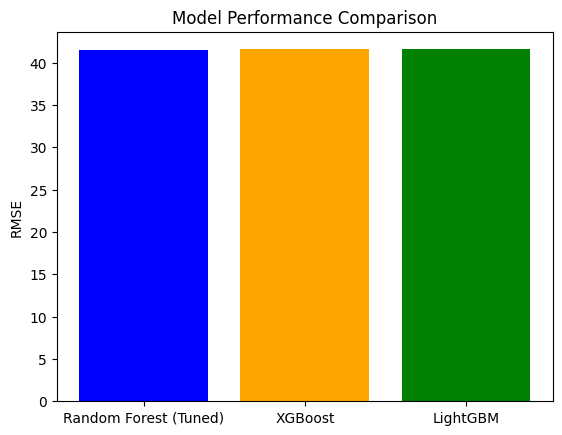

In [18]:
import matplotlib.pyplot as plt

# RMSE values
models = ['Random Forest (Tuned)', 'XGBoost', 'LightGBM']
rmse_values = [best_score ** 0.5, rmse_xgb, rmse_lgb]

# Plot
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.show()


 99%|===================| 4080/4127 [00:24<00:00]       

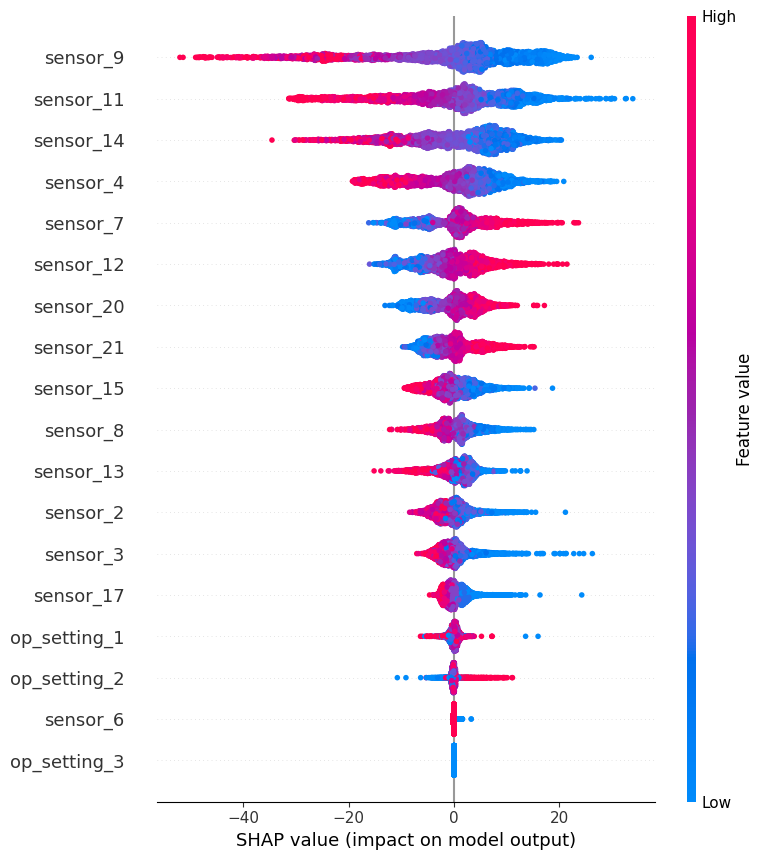

In [19]:
import shap

# Initialize SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for validation data
shap_values = explainer(X_val)

# Display SHAP values summary plot
shap.summary_plot(shap_values, X_val)


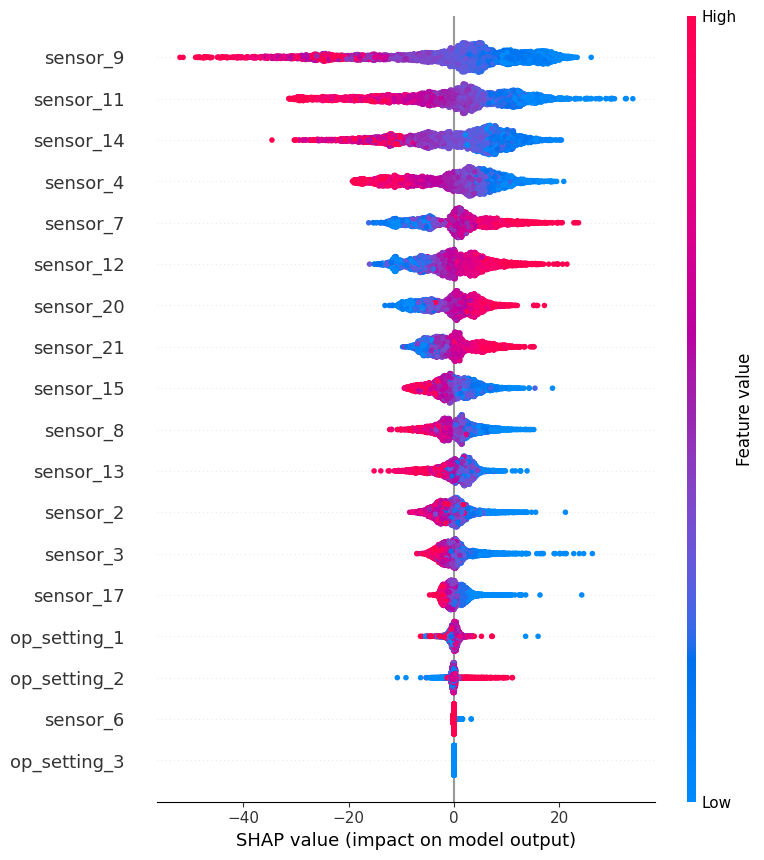

In [20]:
# Summary plot for feature importance
shap.summary_plot(shap_values, X_val)
